### Классификация sst2

In [1]:
!pip install datasets --quiet
!pip install transformers --quiet

     |████████████████████████████████| 325 kB 5.5 MB/s 
     |████████████████████████████████| 212 kB 30.4 MB/s 
     |████████████████████████████████| 134 kB 36.4 MB/s 
     |████████████████████████████████| 67 kB 4.2 MB/s 
     |████████████████████████████████| 1.1 MB 35.4 MB/s 
     |████████████████████████████████| 127 kB 10.5 MB/s 
     |████████████████████████████████| 144 kB 16.7 MB/s 
     |████████████████████████████████| 271 kB 38.6 MB/s 
     |████████████████████████████████| 94 kB 2.6 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


Загрузим sst2 датасет с рецензиями на фильмы

In [1]:
from datasets import load_dataset
dataset = load_dataset('glue', 'sst2')

Reusing dataset glue (/root/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

In [18]:
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1821
    })
})

Посмотрим на предложения в датасете

In [17]:
dataset['train']['sentence'][:10]

['hide new secretions from the parental units ',
 'contains no wit , only labored gags ',
 'that loves its characters and communicates something rather beautiful about human nature ',
 'remains utterly satisfied to remain the same throughout ',
 'on the worst revenge-of-the-nerds clichés the filmmakers could dredge up ',
 "that 's far too tragic to merit such superficial treatment ",
 'demonstrates that the director of such hollywood blockbusters as patriot games can still turn out a small , personal film with an emotional wallop . ',
 'of saucy ',
 "a depressed fifteen-year-old 's suicidal poetry ",
 "are more deeply thought through than in most ` right-thinking ' films "]

Для начала попробуем получить эмбеддинги предложений суммируя эмбеддинги слов, из которых оно состоит. На получившиеся эмбеддинги обучим нейросетевой классификатор

In [21]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stopWords = set(stopwords.words('english'))

wnl = nltk.WordNetLemmatizer()

def preproc_nltk(text):
    return " ".join([wnl.lemmatize(word) for word in word_tokenize(text.lower()) if word not in stopWords])

In [ ]:
!pip install fasttext --quiet

In [ ]:
import fasttext.util
fasttext.util.download_model('en', if_exists='ignore')
embeddings_pretrained = fasttext.load_model('cc.en.300.bin')

In [ ]:
for t in ['train', 'validation', 'test']:
    t_dataset = dataset[t]

    embeddings = []

    for data in t_dataset:
        sent, label = data['sentence'], data['label']

        sent = preproc_nltk(sent)

        emb = embeddings_pretrained.get_sentence_vector(sent)

        embeddings.append(emb)

    dataset[t] = dataset[t].add_column('embedding', embeddings)

In [26]:
import torch
from torch import nn, optim

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [32]:
in_dim = 300
out_dim = 2
p = 0.2

torch.manual_seed(1)

model = nn.Sequential(
    nn.Linear(in_dim, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(p),

    nn.Linear(512, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(p),

    nn.Linear(512, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Dropout(p),

    nn.Linear(256, out_dim)
).to(device)

In [28]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset['train'], batch_size=128, shuffle=False)
val_loader = DataLoader(dataset['validation'], batch_size=128, shuffle=False)

In [ ]:
from meltools import train_fc, evaluate_fc, train_model, evaluate_model, get_model_and_tokenizer

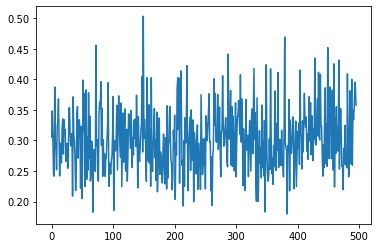

100%|██████████| 527/527 [00:29<00:00, 17.83it/s]


In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)
scheduler = optim.lr_scheduler.StepLR(optimizer, gamma=0.2, step_size=200)

train_fc(model, optimizer, criterion, scheduler, train_loader,
            num_epochs=3)

In [34]:
evaluate_fc(model, val_loader)

Accuracy: 0.8061926364898682
F1 score: 0.8132596685082873


Попробуем использовать трансформеры. Будем извлекать эмбеддинги предложений из предобученных моделей и на них обучать классификатор. Это наилучший способ получения эмбеддингов предложений за счет большого датасета, на котором обучался трансформер и механизма внимания, который позволяет учитывать семантические связи между словами и получать лучшее представление предложения, чем сумма эмбеддингов слов


### Bert

In [64]:
model, tokenizer = get_model_and_tokenizer("bert-base-uncased")

model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [65]:
evaluate_model(model, tokenizer, val_loader)

Accuracy: 0.4919724762439728
F1 score: 0.00449438202247191


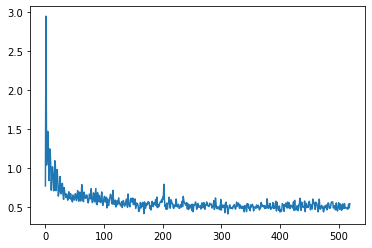

100%|██████████| 527/527 [06:22<00:00,  1.38it/s]


In [66]:
# bs 128

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)
scheduler = optim.lr_scheduler.StepLR(optimizer, gamma=0.1, step_size=200)

train_model(model, tokenizer, optimizer, criterion, scheduler, train_loader,
            num_epochs=1)

In [67]:
evaluate_model(model, tokenizer, val_loader)

Accuracy: 0.7683486342430115
F1 score: 0.7951318458417851


### Distillbert

In [69]:
model, tokenizer = get_model_and_tokenizer("distilbert-base-uncased")

model = model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'pre_classi

In [70]:
evaluate_model(model, tokenizer)

Accuracy: 0.5091742873191833
F1 score: 0.6747720364741641


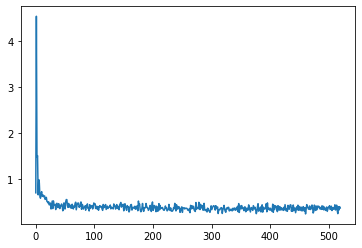

100%|██████████| 527/527 [03:21<00:00,  2.61it/s]


In [71]:
# bs 128

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)
scheduler = optim.lr_scheduler.StepLR(optimizer, gamma=0.1, step_size=200)

train_model(model, tokenizer, optimizer, criterion, scheduler, train_loader, 
            num_epochs=1)

In [72]:
evaluate_model(model, tokenizer, val_loader)

Accuracy: 0.8291284441947937
F1 score: 0.831638418079096


### RoBERTa

In [73]:
model, tokenizer = get_model_and_tokenizer("roberta-base")

model = model.to(device)

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

In [75]:
evaluate_model(model, tokenizer, val_loader)

Accuracy: 0.5091742873191833
F1 score: 0.6747720364741641


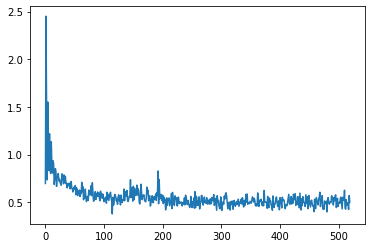

100%|██████████| 527/527 [06:21<00:00,  1.38it/s]


In [76]:
# bs 128

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)
scheduler = optim.lr_scheduler.StepLR(optimizer, gamma=0.1, step_size=200)

train_model(model, tokenizer, optimizer, criterion, scheduler, 
            train_loader, num_epochs=1)

In [77]:
evaluate_model(model, tokenizer, val_loader)

Accuracy: 0.8142201900482178
F1 score: 0.8276595744680851


Рассмотрим более сложные модели, то есть `large` версии BERT и RoBERT'ы

### Large BERT

In [7]:
model, tokenizer = get_model_and_tokenizer("bert-large-uncased")

model = model.to(device)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.25G [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint a

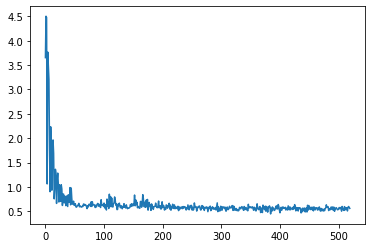

100%|██████████| 527/527 [20:08<00:00,  2.29s/it]


In [10]:
# bs 128

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)
scheduler = optim.lr_scheduler.StepLR(optimizer, gamma=0.1, step_size=200)

train_model(model, tokenizer, optimizer, criterion, scheduler, 
            train_loader, num_epochs=1)

In [11]:
evaluate_model(model, tokenizer, val_loader)

Accuracy: 0.8073394298553467
F1 score: 0.8278688524590164


### Large RoBERTa

In [59]:
model, tokenizer = get_model_and_tokenizer("roberta-large")

model = model.to(device)

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.bias', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.bias', 'classi

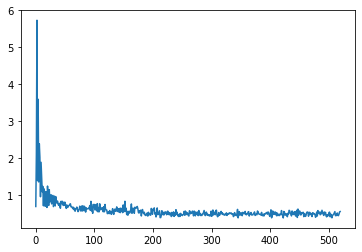

100%|██████████| 527/527 [19:52<00:00,  2.26s/it]


In [14]:
# bs 128

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)
scheduler = optim.lr_scheduler.StepLR(optimizer, gamma=0.1, step_size=200)

train_model(model, tokenizer, optimizer, criterion, scheduler, 
            train_loader, num_epochs=1)

In [15]:
evaluate_model(model, tokenizer, val_loader)

Accuracy: 0.8348624110221863
F1 score: 0.8506224066390041


Из рассмотренных трансформеров наилучшее качество показала RoBERTa, удалось достичь accuracy 83.5% и f1-score 0.85, затем следует DistilBERT с accuracy 82.9% и f1-score 0.83. При этом первый классификатор на сумме эмбеддингов слов обощел BERT более чем на 3% по accuracy